# SHANTIH MLP

# CODE TO START NORMALIZING TEST AND RUN ALL

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os
import math
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import RobustScaler


### Need to add the cse-251-b-2025 folder in the root directory and make sure it has the two .npz files.

In [2]:
train_file = np.load('./cse-251-b-2025/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)

test_file = np.load('./cse-251-b-2025/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


### Code for autoregressive stuff

In [3]:
# CHANGE THESE FOR THE NUMBER OF TIMESTEPS TO USE AND THE NUMBER OF TIMESTEPS AHEAD TO PREDICT
num_features = 50
num_labels = 5

def do_autoregressive(train_data, num_features, num_labels):
    ar_train_x, ar_train_y = [], []

    for s in range(train_data.shape[0]):
        for p in range(num_features, 110 - num_labels):
            train_x, train_y = train_data[s, 0, p-num_features:p, :2], train_data[s, 0, p:p+num_labels, :2] 
            initial_train_x, = train_x[0:1, :].copy()
            train_x -= initial_train_x
            train_y -= initial_train_x
            ar_train_x.append(train_x)
            ar_train_y.append(train_y)
    ar_train_x = np.stack(ar_train_x, axis=0)
    ar_train_y = np.stack(ar_train_y, axis=0)
    return ar_train_x, ar_train_y

### FEATURES

In [52]:
def get_set_with_velocity_and_neighbors(data, k=5):
    positions = data[..., :2].copy()  # Extract (x, y) only
    past_positions = positions[:, 0, :50, :].copy()  # (scenarios, 50, 2)
    future_positions = positions[:, 0, 50:, :].copy()  # (scenarios, 60, 2)
    reference = positions[:, 0, 49, :].copy() # (scenarios, 2)

    # Compute velocity between consecutive timesteps (t1 - t0, t2 - t1, ...)
    velocities = past_positions[:, 1:, :] - past_positions[:, :-1, :]  # (scenarios, 49, 2)

    # Get position of all agents at timestep 50
    agents_at_t50 = positions[:, :, 49, :]  # (scenarios, 50, 2)
    primary_at_t50 = agents_at_t50[:, 0, :]  # (scenarios, 2)
    others_at_t50 = agents_at_t50[:, 1:, :]  # (scenarios, 49, 2)

    # Mask out agents with (0,0) position
    valid_mask = ~(others_at_t50 == 0).all(axis=2)  # (scenarios, 49)
    diffs = others_at_t50 - primary_at_t50[:, None, :]  # (scenarios, 49, 2)
    dists = np.linalg.norm(diffs, axis=2)  # (scenarios, 49)
    dists[~valid_mask] = np.inf

    # Get 5 closest
    nearest_idxs = np.argpartition(dists, kth=5, axis=1)[:, :5]  # (scenarios, 5)
    batch_indices = np.arange(data.shape[0])[:, None]
    closest_diffs = diffs[batch_indices, nearest_idxs]  # (scenarios, 5, 2)

    # subtract the 50th position from past and future positions
    past_positions -= reference[:, None, :] # (scenarios, 50, 2)
    future_positions -= reference[:, None, :] # (scenarios, 60, 2)

    # Final feature shape: (scenarios, 50+49+5, 2)
    # removed closest_diffs
    all_features = np.concatenate([past_positions, velocities[:, -10:, :]], axis=1)
    return all_features, future_positions

def get_delta_to_delta_dataset(data):
    positions = data[..., :2].copy()  # (scenarios, agents, timesteps, 2)
    
    # Extract primary agent's trajectory
    primary_traj = positions[:, 0, :, :].copy()  # (scenarios, timesteps=110, 2)

    # Split into past and future
    past_positions = primary_traj[:, :50, :].copy()  # (scenarios, 50, 2)
    future_positions = primary_traj[:, 49:, :].copy()  # (scenarios, 60, 2)

    # Compute deltas (velocities)
    past_deltas = past_positions[:, 1:, :] - past_positions[:, :-1, :]  # (scenarios, 49, 2)
    future_deltas = future_positions[:, 1:, :] - future_positions[:, :-1, :]  # (scenarios, 59, 2)

    return past_deltas, future_deltas

def get_delta_to_delta_dataset_with_dist(data, k=5, epsilon=3.0):
    positions = data[..., :2].copy()  # (scenarios, agents, timesteps, 2)

    # Primary agent trajectory
    primary_traj = positions[:, 0, :, :].copy()  # (scenarios, 110, 2)
    past_positions = primary_traj[:, :50, :].copy()  # (scenarios, 50, 2)
    future_positions = primary_traj[:, 49:, :].copy()  # (scenarios, 61, 2)

    # Deltas
    past_deltas = past_positions[:, 1:, :] - past_positions[:, :-1, :]  # (scenarios, 49, 2)
    future_deltas = future_positions[:, 1:, :] - future_positions[:, :-1, :]  # (scenarios, 60, 2)

    # Agent positions at t=49 and t=50
    agents_at_t49 = positions[:, :, 48, :]  # (scenarios, agents, 2)
    agents_at_t50 = positions[:, :, 49, :]  # (scenarios, agents, 2)

    primary_at_t50 = agents_at_t50[:, 0, :]  # (scenarios, 2)
    others_at_t50 = agents_at_t50[:, 1:, :]  # (scenarios, agents-1, 2)
    others_at_t49 = agents_at_t49[:, 1:, :]  # (scenarios, agents-1, 2)

    # Compute relative positions and distances
    diffs = others_at_t50 - primary_at_t50[:, None, :]  # (scenarios, agents-1, 2)
    dists = np.linalg.norm(diffs, axis=2)  # (scenarios, agents-1)

    # Mask out invalid agents (all-zero position at t=50)
    valid_mask = ~(others_at_t50 == 0).all(axis=2)  # (scenarios, agents-1)
    dists[~valid_mask] = np.inf

    # Sort by distance
    sorted_idxs = np.argsort(dists, axis=1)[:, :k]  # (scenarios, k)
    batch_indices = np.arange(data.shape[0])[:, None]

    sorted_diffs = diffs[batch_indices, sorted_idxs]  # (scenarios, k, 2)
    sorted_dists = dists[batch_indices, sorted_idxs]  # (scenarios, k)
    sorted_valid = sorted_dists <= epsilon  # (scenarios, k)

    # Unit direction to ego (a, b)
    unit_vectors = np.zeros_like(sorted_diffs)
    norm_mask = (sorted_dists > 1e-6) & sorted_valid
    unit_vectors[norm_mask] = sorted_diffs[norm_mask] / sorted_dists[norm_mask][..., None]

    # Raw deltas for neighbors between t=49 and t=50 (c, d)
    velocity_deltas = others_at_t50 - others_at_t49  # (scenarios, agents-1, 2)

    # Mask out invalid deltas: agent must exist at both t=49 and t=50
    valid_prev_mask = ~(others_at_t49 == 0).all(axis=2)  # (scenarios, agents-1)
    valid_both_mask = valid_mask & valid_prev_mask  # both t=49 and t=50 must be valid
    velocity_deltas[~valid_both_mask] = 0

    sorted_velocities = velocity_deltas[batch_indices, sorted_idxs]  # (scenarios, k, 2)

    # Combine (a, b) and (c, d) → shape: (scenarios, k, 4)
    neighbor_features = np.concatenate([unit_vectors, sorted_velocities], axis=2)

    # Final features: past deltas + k * 2 rows of neighbor features
    neighbor_features_reshaped = neighbor_features.reshape(data.shape[0], k * 2, 2)  # 2 rows per neighbor

    # Compute average deltas over the last 5, 10, 15, 20 time steps
    avg_5 = past_deltas[:, -5:, :].mean(axis=1, keepdims=True)   # (scenarios, 1, 2)
    avg_10 = past_deltas[:, -10:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_15 = past_deltas[:, -15:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_20 = past_deltas[:, -20:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_25 = past_deltas[:, -25:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_30 = past_deltas[:, -30:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_35 = past_deltas[:, -35:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)
    avg_40 = past_deltas[:, -40:, :].mean(axis=1, keepdims=True) # (scenarios, 1, 2)

    avg_deltas = np.concatenate([avg_5, avg_10, avg_15, avg_20, avg_25, avg_30, avg_35, avg_40], axis=1)  # (scenarios, 4, 2)

    all_features = np.concatenate([past_deltas, avg_deltas], axis=1)  # (scenarios, 49 + 2k, 2)

    return all_features, future_deltas


### Test data

In [53]:
test_x = test_data[:, 0, :50, :2].copy()
print(test_data.shape)
print(train_data.shape)

initial_test_x = test_x[:, 49:50, :].copy()
test_x -= initial_test_x

#test_x, _ = get_set_with_velocity_and_neighbors(test_data)
test_x, _ = get_delta_to_delta_dataset(test_data)

print(test_x.shape)
print(initial_test_x[0])
print(test_x[0])

(2100, 50, 50, 6)
(10000, 50, 110, 6)
(2100, 49, 2)
[[5426.23875074 1467.55349867]]
[[ 0.12128604  0.04553863]
 [ 0.03701406  0.01037122]
 [-0.02990402 -0.02496451]
 [-0.00629802  0.00652595]
 [ 0.04809351  0.03284331]
 [ 0.01307027  0.00433511]
 [-0.05898861 -0.03758746]
 [-0.04201422 -0.02902212]
 [-0.05361393  0.01658272]
 [ 0.05252811  0.04492767]
 [-0.01139401 -0.03430366]
 [ 0.00396854 -0.00433321]
 [ 0.03280911  0.00132731]
 [-0.01904475 -0.02273397]
 [-0.0460643   0.00557459]
 [ 0.04866884  0.0627614 ]
 [ 0.05472109  0.01149773]
 [-0.03062688 -0.06699287]
 [-0.11967064 -0.12106375]
 [ 0.00154388  0.03845817]
 [ 0.07998967  0.08284343]
 [ 0.08007616  0.03208793]
 [-0.02642116 -0.01883862]
 [-0.01981097 -0.03670711]
 [ 0.03821593  0.03173192]
 [-0.00350626  0.05247684]
 [ 0.03023498  0.01627248]
 [-0.03080952 -0.03115474]
 [-0.04863495 -0.01804326]
 [ 0.01527481  0.04150443]
 [ 0.04803333  0.0171423 ]
 [-0.02874657 -0.05665743]
 [-0.03758744 -0.03070605]
 [ 0.00104522  0.01831192

### Training and validation sets

In [54]:
#SET TO FALSE IF YOU DONT WANT AUTOREGRESSIVE
auto_regressive = False
#auto_regressive = True


train_x, train_y = train_data[:, 0, :50, :2].copy(), train_data[:, 0, 50:, :2].copy()
print(train_x[0][0], train_y[0][0])
initial_train_x = train_x[:, 49:50, :].copy()
train_x -= initial_train_x
train_y -= initial_train_x

if auto_regressive:
    train_x, train_y = do_autoregressive(train_data, num_features, num_labels)
    print(train_x.shape, train_y.shape)

#adding new velocity and neighbour info
#train_x, train_y = get_set_with_velocity_and_neighbors(train_data)
train_x, _ = get_delta_to_delta_dataset_with_dist(train_data, 5, 100)

#scaler = RobustScaler()  # scales based on IQR (25th to 75th percentile)
#scaler = RobustScaler(quantile_range=(5, 90))
#train_x_reshaped = train_x.reshape(-1, train_x.shape[-1])  # reshape to 2D
#scaler.fit(train_x_reshaped)

#train_x = scaler.transform(train_x_reshaped).reshape(train_x.shape)

train_x = np.tanh(train_x)

print(train_x.shape, train_y.shape)
id = 8
print(train_x[id], train_y[id])


[ 338.59322192 -672.21574762] [ 287.20506697 -656.44786782]
(10000, 57, 2) (10000, 60, 2)
[[ 0.55849306  0.10015362]
 [ 0.66522448  0.12457196]
 [ 0.74806848  0.14738635]
 [ 0.80986049  0.16790261]
 [ 0.85389359  0.18515203]
 [ 0.88358034  0.19811774]
 [ 0.90231756  0.20614221]
 [ 0.91275909  0.20781341]
 [ 0.91590572  0.20319398]
 [ 0.91101703  0.19095603]
 [ 0.89646018  0.17055918]
 [ 0.89746213  0.16392903]
 [ 0.89868952  0.15816173]
 [ 0.90029771  0.15164591]
 [ 0.90158914  0.14550243]
 [ 0.90291482  0.13818431]
 [ 0.90423018  0.13161276]
 [ 0.90529291  0.12425328]
 [ 0.90643492  0.11709915]
 [ 0.90753082  0.10933854]
 [ 0.90808434  0.10138061]
 [ 0.90912339  0.09322801]
 [ 0.91005992  0.08461281]
 [ 0.91063521  0.07579599]
 [ 0.91113619  0.06610949]
 [ 0.91166541  0.0563938 ]
 [ 0.91225444  0.04715328]
 [ 0.91266123  0.03768788]
 [ 0.91319134  0.0285474 ]
 [ 0.91336008  0.01938875]
 [ 0.91362259  0.01072185]
 [ 0.91379352  0.00138267]
 [ 0.91367716 -0.00663499]
 [ 0.91378608 -0.01

In [55]:
ratio_validation = 0.2
perm = torch.randperm(train_x.shape[0])
idx = int(ratio_validation * train_x.shape[0])

new_train_x = train_x[perm[idx:]].copy()
new_train_y = train_y[perm[idx:]].copy()

val_x = train_x[perm[:idx]].copy()
val_y = train_y[perm[:idx]].copy()

print(new_train_x.shape, new_train_y.shape)
print(val_x.shape, val_y.shape)

(8000, 57, 2) (8000, 60, 2)
(2000, 57, 2) (2000, 60, 2)


(10000, 57, 2)
(1140000,)
0.9341564817382437
0


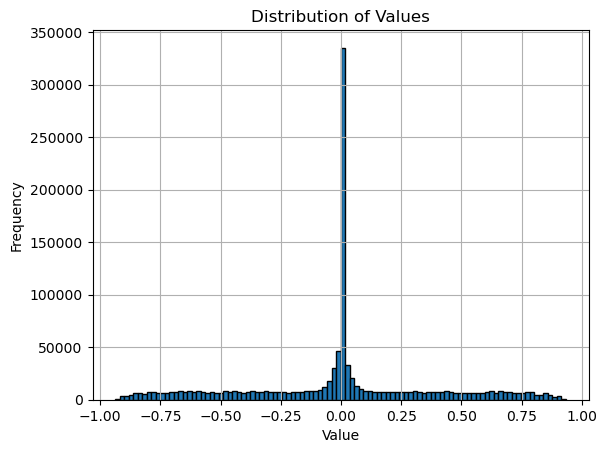

In [56]:
# Example list
values = train_x.flatten().copy()
print(train_x.shape)
print(values.shape)
print(max(values))

limit = 100
outs = [x for x in values if x > limit or x < -limit]
print(len(outs))

plt.hist(values, bins=100, edgecolor='black')
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Code for adding closest agent feature (in progress)

### Play with the number of layers and sizes. My computer takes too long

In [57]:
class ComplexMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(ComplexMLP, self).__init__()

        # Define the layers
        self.input_features = input_features
        self.output_features = output_features
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 2048),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(256, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x

In [91]:
class PathMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(PathMLP, self).__init__()

        self.input_features = input_features
        self.output_features = output_features

        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 2)  # Outputs (a, b)
        )

        # Prepare a (60, 1) tensor for multiplying with (a, b)
        self.register_buffer('step_factors', torch.arange(1, output_features / 2 + 1).float().unsqueeze(1))  # shape (60, 1)

    def forward(self, x):
        x = self.flatten(x)
        delta = self.mlp(x)  # shape (batch_size, 2)

        # Expand deltas into full 60-step trajectory
        # delta: (batch_size, 2)
        # step_factors: (60, 1)
        # output: (batch_size, 60, 2)
        trajectory = self.step_factors * delta.unsqueeze(1)  # Broadcasting (batch, 1, 2) * (60, 1)
        trajectory = trajectory.view(x.size(0), -1)
        return trajectory

In [92]:
def predict(model, x):
    model.eval()
    with torch.no_grad():
        x_tensor = torch.FloatTensor(x).reshape((-1, input_features))
        predictions = model(x_tensor).reshape((-1, int(output_features / 2), 2))
        return predictions.numpy()


In [93]:
def evaluate_model(model, x, y, dataset):
    pred_y = predict(model, x)
        
    mse = ((pred_y - y) ** 2).mean()
    print("Model MSE evaluated on", dataset, ":", mse.item())
    return mse

In [94]:
# Example of how to prepare data and train the model

def new_train_model(model, criterion, optimizer, train_x, train_y, val_x, val_y, batch_size=64, epochs=10):
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, model.input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, model.output_features))
    print(X_train_tensor.shape)
    print(y_train_tensor.shape)

    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_maes = []

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0

        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # could do something here to transform the model outputs 

            # Calculate loss
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print epoch statistics
        #print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
        train_mse = evaluate_model(model, train_x, train_y, "TRAIN")
        evaluate_model(model, val_x, val_y, "VALIDATION")

        train_maes.append(math.sqrt(train_mse))

    return model, train_maes


### Run this to train the model. You can interrupt it if it takes too long and continue on

In [84]:
input_features = 57 * 2  # = 100
output_features = 60 * 2

if auto_regressive:
    input_features = num_features * 2
    output_features = num_labels * 2

print(input_features, output_features)

#norm_model = ComplexMLP(input_features, output_features)
norm_model = PathMLP(input_features, output_features)


114 120


In [87]:
# Define loss function and optimizer
criterion = nn.MSELoss()

optimizer = optim.Adam(norm_model.parameters(), lr=0.00001)

norm_model, train_maes = new_train_model(norm_model, criterion, optimizer, new_train_x, new_train_y, val_x, val_y, batch_size=64, epochs=150)

torch.Size([8000, 114])
torch.Size([8000, 120])
Epoch 1, Loss: 11.3882
Model MSE evaluated on TRAIN : 11.251946940871745
Model MSE evaluated on VALIDATION : 11.570846578028139
Epoch 2, Loss: 11.3525
Model MSE evaluated on TRAIN : 11.284206385199687
Model MSE evaluated on VALIDATION : 11.642494000163424
Epoch 3, Loss: 11.3353
Model MSE evaluated on TRAIN : 11.405375450360605
Model MSE evaluated on VALIDATION : 11.71601211310609
Epoch 4, Loss: 11.3472
Model MSE evaluated on TRAIN : 11.284828919377698
Model MSE evaluated on VALIDATION : 11.572012681400166
Epoch 5, Loss: 11.3479
Model MSE evaluated on TRAIN : 11.331556975934275
Model MSE evaluated on VALIDATION : 11.674241541055551
Epoch 6, Loss: 11.3342
Model MSE evaluated on TRAIN : 11.344499806324137
Model MSE evaluated on VALIDATION : 11.67544451828761
Epoch 7, Loss: 11.3247
Model MSE evaluated on TRAIN : 11.208479731744335
Model MSE evaluated on VALIDATION : 11.52668222246937
Epoch 8, Loss: 11.3264
Model MSE evaluated on TRAIN : 11.41

In [64]:
evaluate_model(norm_model, train_x, train_y, "TRAIN")
evaluate_model(norm_model, val_x, val_y, "VALIDATION")

RuntimeError: shape '[-1, 134]' is invalid for input of size 1140000

### Need this method for autoregressive inference. Basically doing and shifting thing

In [65]:
def ar_inference(norm_model, feature):
    print('in', feature.shape)
    answer = []
    for i in range(int(60 / num_labels)):
        pred = predict(norm_model, feature)
        answer.append(pred)
        feature = np.concatenate((feature, pred), axis=1)
        feature = feature[:, -num_features:, :]
    answer = np.concatenate(answer, axis=1)
    return answer

def delta_inference(model, feature):
    pred = predict(model, feature)
    pred_positions = np.cumsum(pred, axis=1)
    return pred_positions


## Remember you need to delete the shantih_mlp.csv if you want to make a new one. I don't think it rewrites it

In [66]:
print(test_x.shape)
if not auto_regressive:
    pred_y = predict(norm_model, test_x)
else:
    pred_y = ar_inference(norm_model, test_x)

#uncomment if not doing deltas
#pred_y = delta_inference(norm_model, test_x)
print(pred_y[0])
pred_y += initial_test_x
print(initial_test_x[0])
print(pred_y[0])

# Code to write the prediction to file
pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

output_df.index.name = 'index'

output_df.to_csv('shantih_mlp.csv')

(2100, 49, 2)


RuntimeError: shape '[-1, 134]' is invalid for input of size 205800

(2000, 57, 2)
(2000, 60, 2)
(2000, 60, 2)


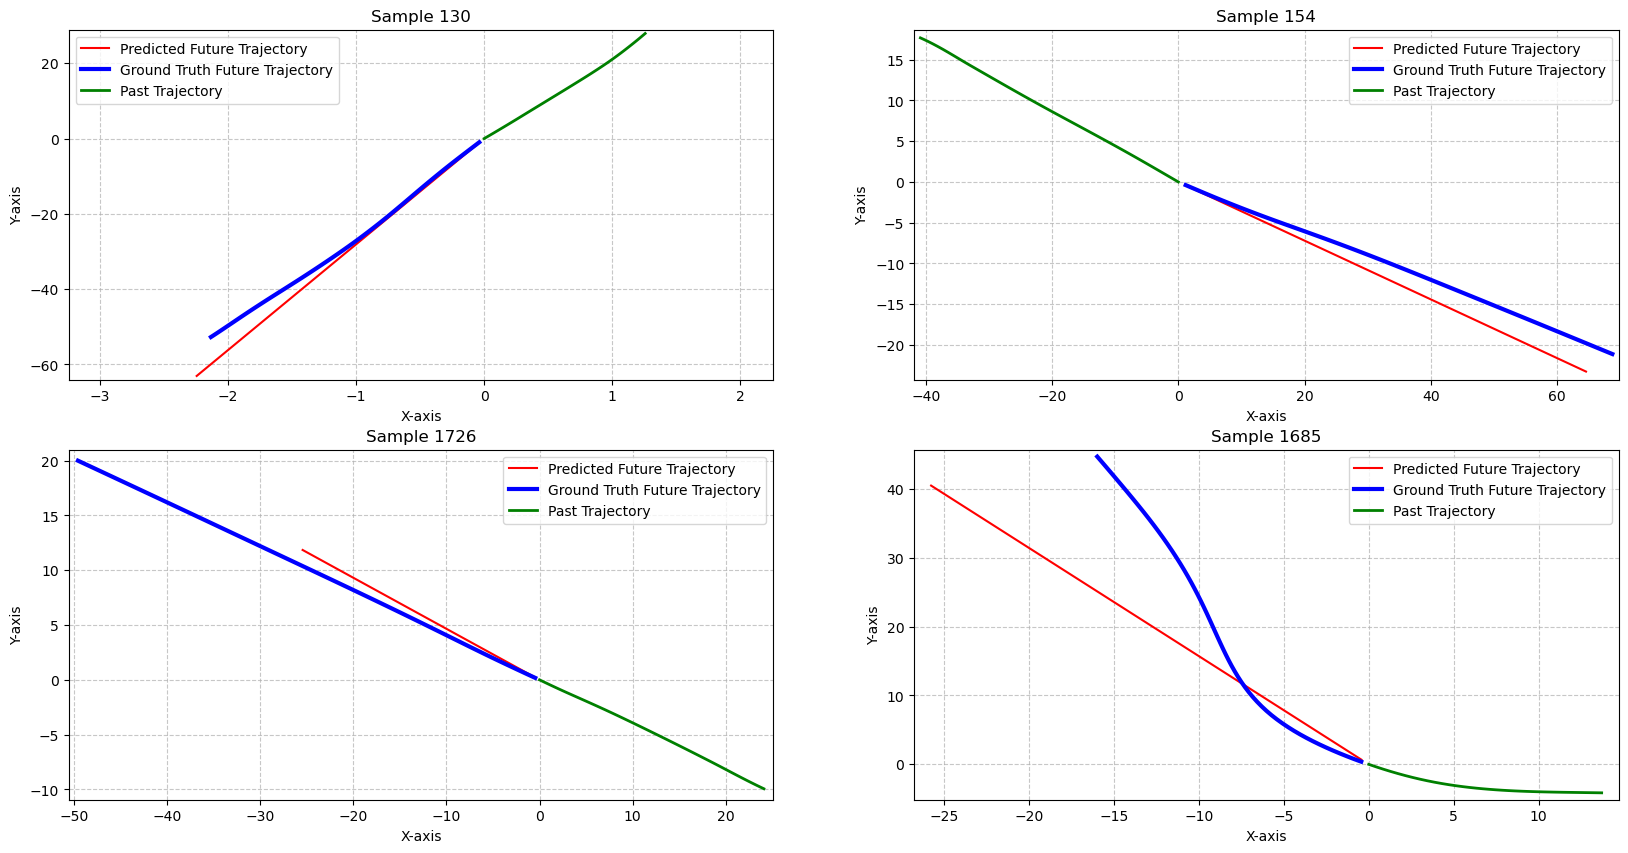

In [95]:
pred_y = predict(norm_model, val_x)

print(val_x.shape)
print(val_y.shape)
print(pred_y.shape)

def plot_trajectory(ax, past, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[:60,0], pred[:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[:60,0], gt[:60,1], color='blue', label='Ground Truth Future Trajectory', linewidth=3)

    ax.plot(past[:50, 0], past[:50, 1], color='green', label='Past Trajectory', linewidth=2)
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    x_max = max(x_max, past[..., 0].max())
    x_min = min(x_min, past[..., 0].min())
    y_max = max(y_max, past[..., 1].max())
    y_min = min(y_min, past[..., 1].min())
    
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

random_indices = random.sample(range(val_y.shape[0]), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects


for i, idx in enumerate(random_indices):

    x_deltas = val_x[idx][:49, 0]
    y_deltas = val_x[idx][:49, 1]
    
    # Reverse and negate deltas to walk backwards
    x_reversed_path = np.cumsum(x_deltas[::-1] * -1)[::-1]
    y_reversed_path = np.cumsum(y_deltas[::-1] * -1)[::-1]
    
    # Append origin (0, 0) at the end — corresponds to t=49
    x_full = np.append(x_reversed_path, 0)
    y_full = np.append(y_reversed_path, 0)
    
    # Stack into (50, 2) shape
    past_reconstructed = np.stack([x_full, y_full], axis=1)

    plot_trajectory(axes[i], past_reconstructed, pred_y[idx], val_y[idx], title=f"Sample {idx}")
    axes[i].legend()

plt.show()